In [2]:
!pip install wget

  Using cached wget-3.2.zip (10 kB)
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9686 sha256=978fb293121e275c92a55527cc3e63a06ce613ffe544a1fcaa8274d287af70a7
  Stored in directory: c:\users\egora\appdata\local\pip\cache\wheels\a1\b6\7c\0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [1]:
import os
import wget
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

In [ ]:
wget.download('http://www.cs.toronto.edu/~rkiros/models/dictionary.txt')
wget.download('http://www.cs.toronto.edu/~rkiros/models/utable.npy')
wget.download('http://www.cs.toronto.edu/~rkiros/models/btable.npy')
wget.download('http://www.cs.toronto.edu/~rkiros/models/uni_skip.npz')
wget.download('http://www.cs.toronto.edu/~rkiros/models/uni_skip.npz.pkl')
wget.download('http://www.cs.toronto.edu/~rkiros/models/bi_skip.npz')
wget.download('http://www.cs.toronto.edu/~rkiros/models/bi_skip.npz.pkl')

In [2]:
import skipthoughts
import nltk
model = skipthoughts.load_model()

Loading model parameters...
Compiling encoders...


D:\Programming\envs\tf\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
D:\Programming\envs\tf\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"
D:\Programming\envs\tf\lib\site-packages\theano\scan_module\scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available.

Loading tables...
Packing up...


In [3]:
class Generator(nn.Module):
    def __init__(self, noise_size = 100, embed_size = 4800, ner_fc1 = 256, ner_fc2 = 64, gen_conv_ch = 64):
        super(Generator, self).__init__()
        self.noise_shape = noise_size
        self.embed_shape = embed_size
        self.ner_fc1 = ner_fc1
        self.ner_fc2 = ner_fc2

        self.FC1 = nn.Linear(self.embed_shape, self.ner_fc1)
        self.emb_leak = nn.LeakyReLU()
        self.FC2 = nn.Linear(self.noise_shape + self.ner_fc1, 8*8*8*self.ner_fc2)
        self.emb_bn = nn.BatchNorm2d(8*self.ner_fc2)
        self.emb_rl = nn.ReLU()

        self.net = nn.Sequential(
            nn.ConvTranspose2d(8*self.ner_fc2, gen_conv_ch*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(gen_conv_ch*4),
            nn.ReLU(),
            nn.ConvTranspose2d(gen_conv_ch*4, gen_conv_ch*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(gen_conv_ch*2),
            nn.ReLU(),
            nn.ConvTranspose2d(gen_conv_ch*2, gen_conv_ch, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(gen_conv_ch),
            nn.ReLU(),
            nn.ConvTranspose2d(gen_conv_ch, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
        self.intialize_weights()

    def forward(self, noise, embed):
        batch_size = noise.shape[0]
        latent_rep = self.emb_leak(self.FC1(embed))
        x = torch.cat((noise, latent_rep), 1)
        repr = self.FC2(x)
        repr = self.emb_rl(self.emb_bn(repr.reshape((batch_size, 8*self.ner_fc2, 8, 8))))

        img_f = self.net(repr)
        return (img_f / 2.0) + 0.5
    
    def intialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()




class Discriminator(nn.Module):
    def __init__(self, embed_size = 4800, ner_fc1 = 256, out_net = 384, gen_conv_ch = 64):
        super(Discriminator, self).__init__()
        self.embed_shape = embed_size
        self.ner_fc1 = ner_fc1
        self.out_net = out_net

        self.FC1 = nn.Linear(self.embed_shape, self.ner_fc1)

        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, self.out_net, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(self.out_net),
            nn.LeakyReLU(0.2)
        )

        self.conv_cat = nn.Conv2d(self.out_net + self.ner_fc1, 512, kernel_size=1, stride=1)
        self.last_fc = nn.Linear(8*8*512, 64)
        self.FC_real_fake = nn.Linear(64, 1)
        self.FC_class = nn.Linear(64, 102)
        self.leak = nn.LeakyReLU()
        self.sig = nn.Sigmoid()
        self.intialize_weights()
        
    def forward(self, img, emb):
        batch_size = img.shape[0]
        x = self.FC1(emb).reshape(batch_size, self.ner_fc1, -1).unsqueeze(2)
        latent_repr = x.repeat(1, 1, 8, 8)

        conved_img = self.net(img)

        repr_cat = torch.cat((conved_img, latent_repr), 1)
        to_fc = self.leak(self.conv_cat(repr_cat)).reshape((batch_size, 8*8*512))

        to_fc = self.leak(self.last_fc(to_fc))

        real_fake_dist = self.FC_real_fake(to_fc)
        class_dist = self.sig(self.FC_class(to_fc))

        return real_fake_dist, class_dist
    
    def intialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

In [4]:
device = torch.device('cpu')

netG = Generator()
netG.load_state_dict(torch.load('./models/netG.pt', map_location=device))
netG.eval()

netD = Discriminator()
netD.load_state_dict(torch.load('./models/netD.pt', map_location=device))
netD.eval()

Discriminator(
  (FC1): Linear(in_features=4800, out_features=256, bias=True)
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Conv2d(256, 384, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2)
  )
  (conv_cat): Conv2d(640, 512, kernel_size=(1, 1), stride=(1, 1))
  (last_fc

15


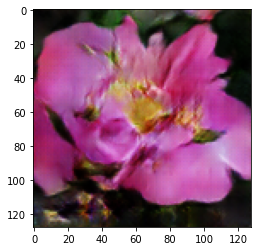

In [5]:
with torch.no_grad():
    text = 'the petals of the flower are pink in color and have a yellow center.'
    emb = skipthoughts.encode(model, [text])
    emb = torch.tensor(emb, device=device)
    image = netG(torch.randn(1,100), emb)
    image = image.squeeze().detach()
    plt.imshow(image.permute(1, 2, 0))

In [21]:
images_n_classes = []
with open('./images_n_classes.txt') as inf:
    for line in inf:
        line = line.strip().split()
        images_n_classes.append((line[0], line[1]))

In [22]:
path_to_classes = './cvpr2016_flowers/text_c10/'
captions = []
for image_name, class_folder in images_n_classes:
    text_name = image_name[:-4] + '.txt'
    with open(path_to_classes + class_folder + '/' + text_name)as inf:
        for line in inf:
            captions.append(line.strip())
            break
len(captions)

8189

In [23]:
captions[:10]

['prominent purple stigma,petals are white inc olor',
 'this flower is blue and green in color, with petals that are oval shaped.',
 'outer petals are green in color and klarger,inner petals are needle shaped',
 'there are several shapes, sizes, and colors of petals on this complex flower.',
 'the stamen are towering over the stigma which cannot be seen.',
 'this flower is white and purple in color, with petals that are oval shaped.',
 'the petals of this flower are green with a long stigma',
 'the blossom has a layer of rounded purple and white petals topped by a layer of fringed purple petals.',
 'this flower is purple and yellow in color, with petals that are oval shaped.',
 'the petals on this flower are white with an elaborate pistil.']

In [25]:
prob_distr = []
with torch.no_grad():
    for text in captions:
        emb = skipthoughts.encode(model, [text])
        emb = torch.tensor(emb, device=device)
        image = netG(torch.randn(1,100), emb)
        _, _, classes = netD(image, emb)
        probs = torch.nn.functional.softmax(classes)
        prob_distr.append(probs)

9


D:\Programming\envs\tf\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


16
14
16
13
16
11
20
16
12
11
12
18
15
11
16
14
13
11
15
17
15
11
16
13
18
12
13
20
18
24
16
15
15
15
15
11
9
16
12
10
12
14
18
11
14
17
16
15
14
16
16
18
16
16
18
15
16
30
10
15
11
33
16
13
17
16
24
32
20
12
23
12
12
11
11
10
12
20
20
12
12
13
10
14
11
16
12
11
11
19
10
30
15
15
11
16
10
12
16
13
10
13
16
12
16
14
11
12
17
16
10
15
18
10
16
20
13
16
15
12
16
16
18
13
25
22
19
14
19
12
22
12
14
12
10
15
17
11
13
18
12
13
16
15
10
25
10
14
24
10
14
32
9
10
16
16
10
19
12
13
16
13
15
14
16
10
16
16
16
16
28
16
19
14
12
24
25
11
25
11
16
21
19
16
11
11
11
15
14
10
13
16
12
16
18
16
18
13
10
12
25
20
38
16
13
10
27
15
11
24
11
14
16
13
14
26
18
14
16
10
16
17
16
21
16
13
22
17
22
16
16
16
12
14
11
14
19
12
15
19
18
15
28
14
23
14
16
16
27
14
15
16
11
12
16
16
11
14
10
11
17
16
15
10
16
14
17
23
16
10
19
13
17
13
14
14
14
14
14
19
16
12
16
16
20
13
18
16
14
15
20
12
16
14
22
18
11
16
10
10
10
13
15
13
15
20
17
14
19
12
11
14
13
14
8
16
13
12
11
26
11
11
15
16
12
19
20
9
10
19
24
13
12
15
13

17
14
11
13
11
12
11
16
9
14
10
14
11
14
22
11
12
15
16
10
16
21
15
19
10
16
10
16
13
16
16
25
16
16
22
10
12
12
15
16
16
14
10
11
13
15
26
16
14
14
14
11
10
13
19
13
10
25
17
11
18
14
13
16
20
15
22
10
12
16
11
21
16
17
13
19
11
12
12
10
16
16
19
22
16
15
15
19
11
15
13
15
15
11
16
11
14
10
13
15
10
19
12
14
10
20
11
12
13
17
19
10
25
10
10
17
12
10
18
11
11
17
15
15
18
17
10
14
15
13
13
13
18
12
11
12
12
16
13
11
15
10
20
14
15
14
13
10
13
13
20
14
15
16
11
13
16
12
10
12
11
18
14
15
12
15
15
9
19
14
13
16
11
11
17
13
17
11
11
11
16
11
10
15
13
19
14
14
14
16
12
16
24
17
18
19
16
11
22
20
19
11
16
12
14
23
16
13
17
11
16
13
11
12
11
12
22
25
16
16
10
20
10
16
16
10
12
15
19
12
15
11
11
17
18
17
12
21
11
19
14
11
21
17
16
20
16
16
15
14
16
10
16
11
13
17
13
19
20
17
16
16
16
14
20
10
16
12
16
11
10
15
15
11
11
13
20
13
12
10
11
18
11
14
13
16
17
15
22
12
15
15
16
18
14
14
10
13
11
18
15
11
14
10
12
10
15
16
32
18
11
17
12
16
17
11
10
16
10
14
15
16
16
17
14
13
11
12
19
12
16
14
10
15


10
16
11
11
14
17
11
16
18
21
11
16
16
10
12
8
17
33
12
11
11
16
13
18
14
21
19
10
22
14
19
16
11
19
11
14
13
14
15
19
10
12
15
12
14
14
20
18
17
14
12
15
15
14
19
13
19
12
15
16
20
19
13
15
14
16
11
10
13
16
16
11
15
13
15
10
15
12
10
13
13
21
13
15
12
19
14
12
16
16
12
10
16
12
15
14
14
16
16
14
18
13
12
16
16
11
15
16
12
13
24
18
10
20
20
12
11
10
12
11
18
13
14
13
10
10
18
16
24
16
14
17
13
10
16
11
14
16
12
12
10
11
16
11
17
10
17
11
10
14
12
11
12
13
7
16
16
15
11
17
15
13
14
12
15
14
16
10
15
12
7
16
13
10
13
17
12
15
16
12
15
19
15
21
14
13
15
11
11
11
11
11
10
11
11
15
12
16
14
13
11
20
21
10
13
18
13
15
16
12
23
12
12
10
16
13
16
11
13
26
15
11
19
13
11
10
11
11
12
13
11
16
12
14
15
17
14
12
22
16
12
16
12
12
28
27
11
27
13
13
17
14
11
13
16
18
18
11
15
16
17
12
16
16
23
15
12
16
18
13
12
16
15
17
16
10
13
16
13
18
18
13
15
16
12
13
12
16
25
13
18
16
12
11
19
14
12
16
14
10
10
18
19
11
10
25
11
13
10
24
15
16
18
11
18
11
19
20
10
11
13
12
16
12
16
10
18
23
14
10
18
18
12
19
1

In [34]:
prob_dist_numpy = np.array([x.numpy() for x in prob_distr])

In [38]:
prob_dist_numpy = prob_dist_numpy.squeeze()

In [39]:
prob_dist_numpy.shape

(8189, 102)

In [55]:
def calculate_inception_score(p_yx, eps=1E-16, splits=150):
    scores = []
    for i in range(splits):
        part = prob_dist_numpy[(i * prob_dist_numpy.shape[0] // splits):((i + 1) * prob_dist_numpy.shape[0] // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

In [56]:
calculate_inception_score(prob_dist_numpy)

(3.2977607, 0.6603655)